In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import zipfile

def load_data(filename : str, ds : str) -> pd.DataFrame:

    with zipfile.ZipFile(filename, 'r') as zipFile:

        # Obtain a list of all files in the zip archive
        fileList = zipFile.namelist()

        # Filter only files with name in db argument ending with .xls
        targetedFileNames = [file for file in fileList if file.endswith(f'{ds}.xls')]

        df = []

        # Obtain dataframe from each file and append it to the list
        for file in targetedFileNames:
            with zipFile.open(file) as f:
                df.extend(pd.read_html(f, encoding="cp1250"))


        # Concatenate all dataframes into one (ignore index for not using index values from original dataframes)
        df = pd.concat(df, ignore_index=True)

        # Drop unnamed columns containing NaN values
        df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
        return df
# Ukol 2: zpracovani dat


def parse_data(df: pd.DataFrame, verbose: bool = False) -> pd.DataFrame:

    regions = {
        0: "PHA", 1: "STC", 2: "JHC", 3: "PLK",
        4: "ULK", 5: "HKK", 6: "JHM", 7: "MSK",
        14: "OLK", 15: "ZLK", 16: "VYS", 17: "PAK",
        18: "LBK", 19: "KVK"
    }

    newDf = df.copy()
    newDf["date"] = pd.to_datetime(newDf["p2a"], format="%d.%m.%Y", errors="coerce")
    newDf["region"] = newDf["p4a"].map(regions)
    newDf = newDf.drop_duplicates(subset='p1', keep=False)

    if(verbose):
        print(f'new_size={(newDf.memory_usage(deep=True).sum() / (1000 * 1000)):.1f} MB')
    return newDf

In [3]:
df = load_data("data_23_24.zip", "nehody")
df2 = parse_data(df, True)
df_conequences = load_data("data_23_24.zip", "nasledky")

new_size=68.3 MB


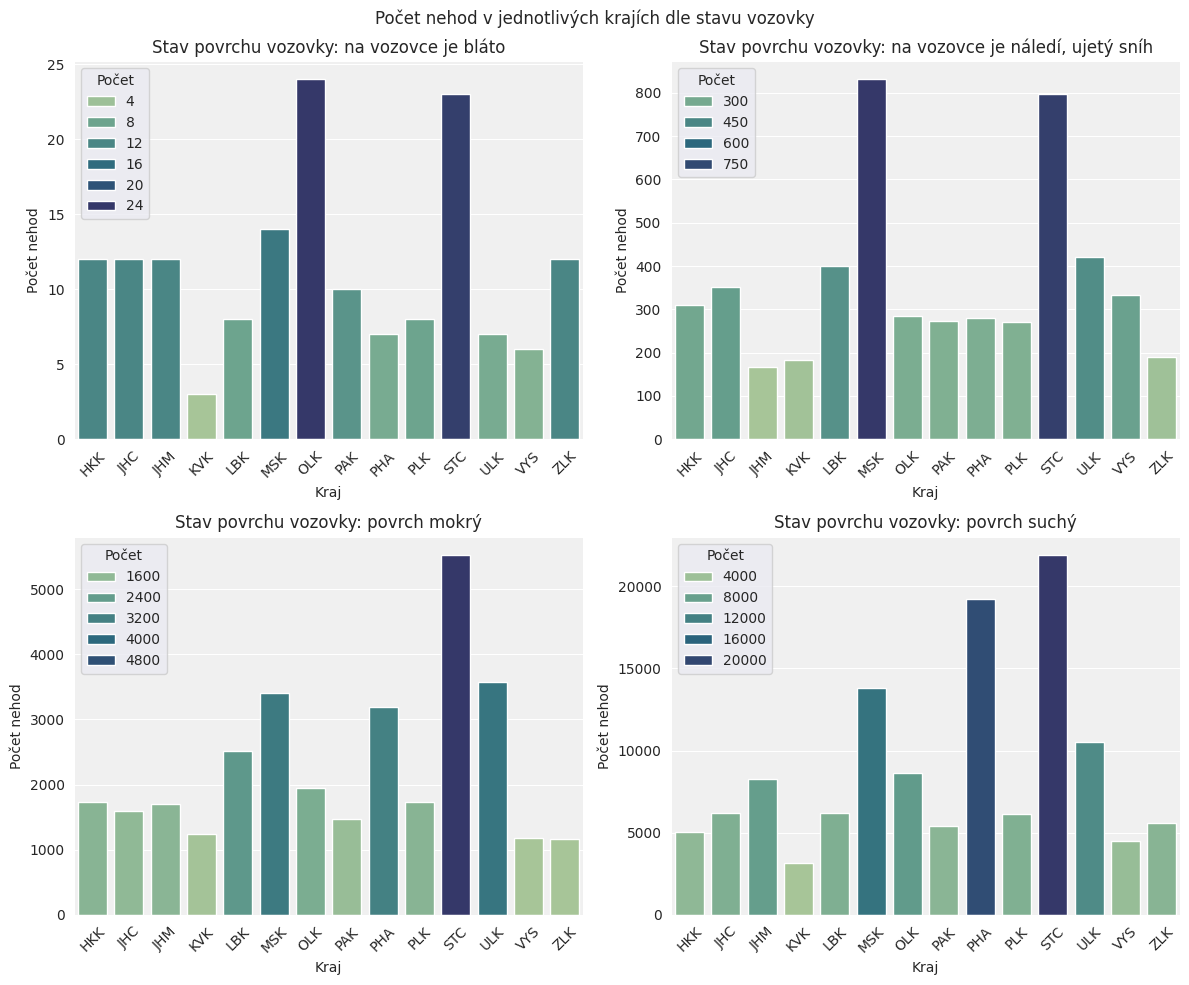

In [134]:
def plot_state(df: pd.DataFrame, fig_location: str = None,
                    show_figure: bool = False):

    roadStates = {
        1: "povrch suchý",
        2: "povrch suchý",
        3: "povrch mokrý",
        4: "na vozovce je bláto",
        5: "na vozovce je náledí, ujetý sníh",
        6: "na vozovce je náledí, ujetý sníh",
    }

    df["roadStates"] = df["p16"].map(roadStates)
    roadsWithRegions = df.groupby(["region", "roadStates"]).size().reset_index(name="count")

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    

    fig.suptitle("Počet nehod v jednotlivých krajích dle stavu vozovky")

    roadStateList = roadsWithRegions["roadStates"].unique()
    for i, axe in enumerate(axes):

        currentRoadState = roadsWithRegions[roadsWithRegions["roadStates"] == roadStateList[i]]
        sns.barplot(data=currentRoadState, x="region", y="count", ax=axe, palette="crest", hue="count")
        sns.set_style("darkgrid")

        axe.legend(title="Počet", loc="upper left")
        axe.set_facecolor('#f0f0f0')
        axe.set_title(f'Stav povrchu vozovky: {roadStateList[i]}')
        axe.tick_params(axis='x', rotation=45)
        axe.set_xlabel("Kraj")
        axe.set_ylabel("Počet nehod")

    plt.tight_layout()

    if(fig_location):
        plt.savefig(fig_location)
    if(show_figure):
        plt.show()
    


plot_state(df2, "01_state.png")

   region   consequences  driver_hurt  count
0     HKK    bez zranění  spolujezdec     96
1     HKK    bez zranění        řidič    307
2     HKK  lehké zranění  spolujezdec     16
3     HKK  lehké zranění        řidič    142
4     HKK  těžké zranění  spolujezdec      4
..    ...            ...          ...    ...
94    ZLK  lehké zranění  spolujezdec     24
95    ZLK  lehké zranění        řidič    212
96    ZLK  těžké zranění  spolujezdec      1
97    ZLK  těžké zranění        řidič      6
98    ZLK       usmrcení        řidič      1

[99 rows x 4 columns]


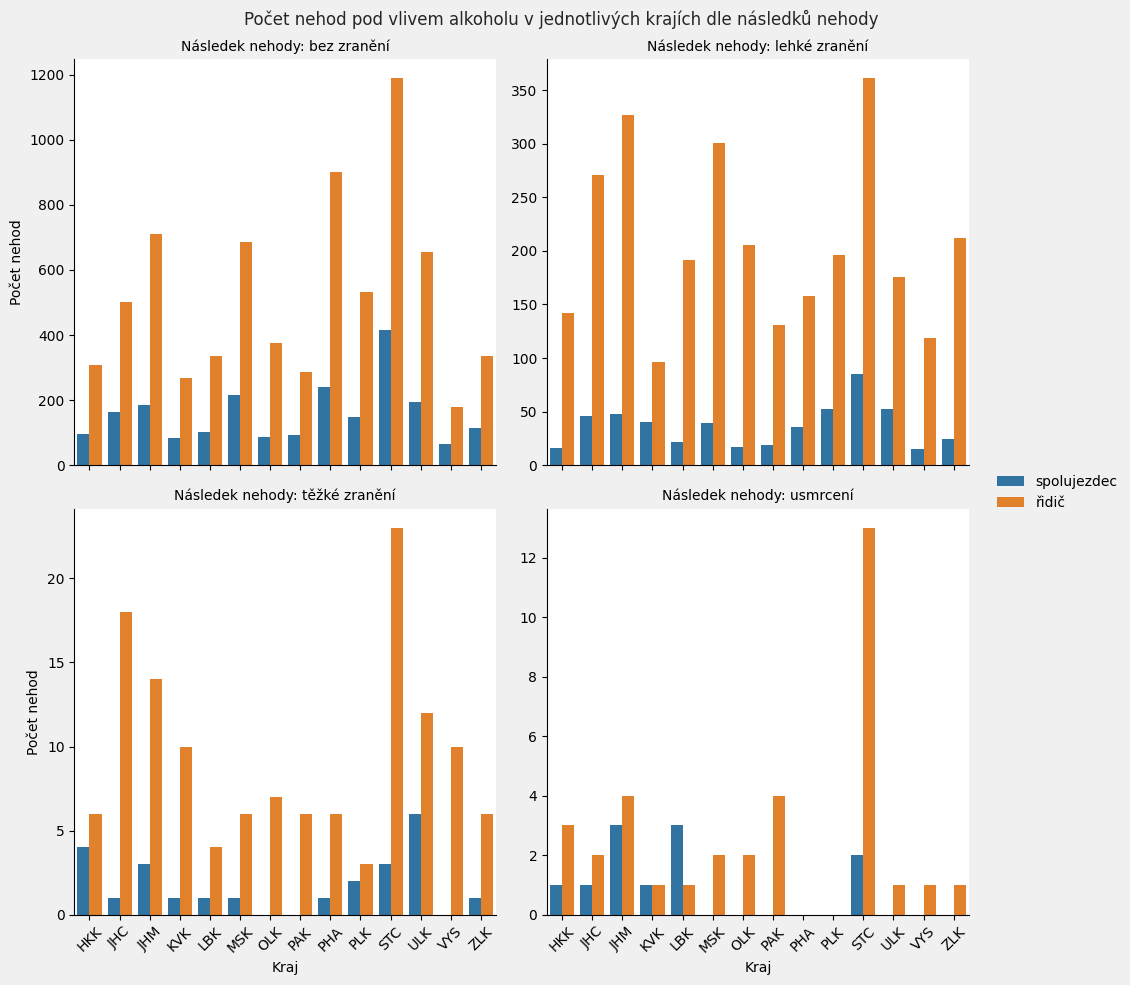

In [34]:
def plot_alcohol(df: pd.DataFrame, df_consequences : pd.DataFrame, 
                 fig_location: str = None, show_figure: bool = False):
    
    dfMerged = pd.merge(df, df_consequences, on="p1", validate="one_to_many")

    injury = {
        1: "usmrcení",
        2: "těžké zranění",
        3: "lehké zranění",
        4: "bez zranění",
    }
    

    dfMerged["driver_hurt"] = dfMerged["p59a"].apply(lambda x: "řidič" if x == 1 else "spolujezdec")
    dfMerged["consequences"] = dfMerged["p59g"].map(injury)
    dfAlcoholOnly = dfMerged[dfMerged["p11"] >= 3]
    # print(dfAlcoholOnly)
    groupedDf = dfAlcoholOnly.groupby(["region", "consequences", "driver_hurt"]).size().reset_index(name="count")
    print(groupedDf)

    g = sns.catplot(data=groupedDf, x="region", y="count", hue="driver_hurt", col="consequences", kind="bar", palette="tab10", col_wrap=2, sharey=False)
    sns.set_style("darkgrid")

    g.set_titles("Následek nehody: {col_name}")
    g.figure.set_facecolor('#f0f0f0')
    g.figure.suptitle("Počet nehod pod vlivem alkoholu v jednotlivých krajích dle následků nehody")
    g.legend.set_title("")
    g.set_ylabels("Počet nehod")
    g.set_xlabels("Kraj")
    g.tick_params(axis='x', rotation=45)
    g.tight_layout()
    if fig_location:
        plt.savefig(fig_location)

    if show_figure:
        plt.show()
    
    


plot_alcohol(df2, df_conequences, "02_alcohol.png", True)

    region       date                             accidentType  count
0      JHM 2023-01-31                                s chodcem     19
1      JHM 2023-01-31                       s domácím zvířetem      4
2      JHM 2023-01-31          s jedoucím nekolejovým vozidlem    102
3      JHM 2023-01-31                            s lesní zvěří      8
4      JHM 2023-01-31                       s pevnou překážkou    112
5      JHM 2023-01-31                               s tramvají      0
6      JHM 2023-01-31                                 s vlakem      0
7      JHM 2023-01-31  s vozidlem zaparkovaným nebo odstaveným    128
8      JHM 2023-02-28                                s chodcem     23
9      JHM 2023-02-28                       s domácím zvířetem      0
10     JHM 2023-02-28          s jedoucím nekolejovým vozidlem     85
11     JHM 2023-02-28                            s lesní zvěří      8
12     JHM 2023-02-28                       s pevnou překážkou     84
13     JHM 2023-02-2

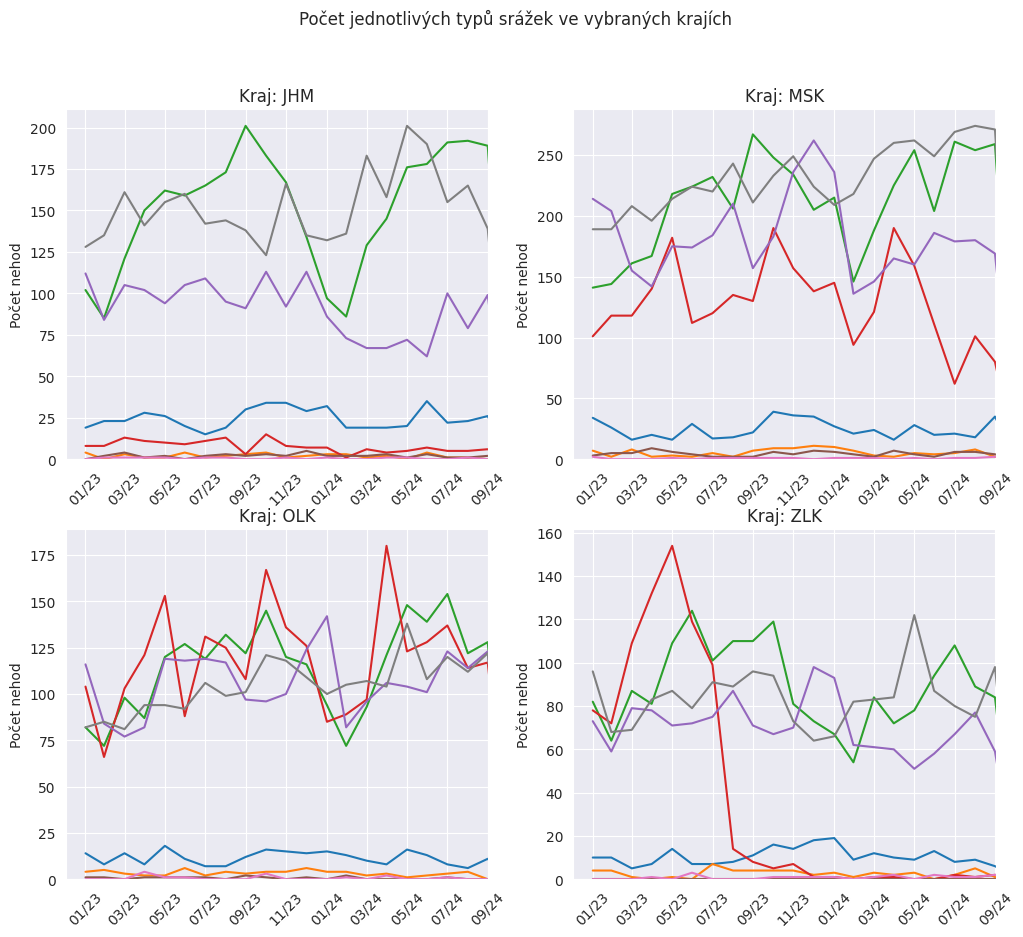

In [ ]:
def plot_type(df: pd.DataFrame, fig_location: str = None,
              show_figure: bool = False):
    
    dfFiltered = df[df["region"].isin(["OLK", "MSK", "JHM", "ZLK"])]

    accidentType = {
        1: "s jedoucím nekolejovým vozidlem",
        2: "s vozidlem zaparkovaným nebo odstaveným",
        3: "s pevnou překážkou",
        4: "s chodcem",
        5: "s lesní zvěří",
        6: "s domácím zvířetem",
        7: "s vlakem",
        8: "s tramvají",
    }
    dfFiltered = dfFiltered.copy()
    dfFiltered["accidentType"] = dfFiltered["p6"].map(accidentType)
    newDf = pd.pivot_table(dfFiltered, index=["date", "region"], columns="accidentType", values="p6", aggfunc="count", fill_value=0)
    # pd.set_option('display.max_rows', None)
    # print(newDf)
    resampledDf = newDf.groupby("region").resample("ME", level="date").sum()
    stackedDf = resampledDf.stack().reset_index(name="count")
    print(stackedDf)

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    

    fig.suptitle("Počet jednotlivých typů srážek ve vybraných krajích")

    regionList = stackedDf["region"].unique()
    for i, axe in enumerate(axes):

        currentRegion = stackedDf[stackedDf["region"] == regionList[i]]
        sns.lineplot(data=currentRegion, x="date", y="count", hue="accidentType", ax=axe, palette="tab10")

        axe.get_legend().remove()
        
        axe.set_xlim(pd.Timestamp("2023-01-01"), pd.Timestamp("2024-10-01"))
        axe.set_ylim(0, None)
        xticks = pd.date_range(start='2023-01-01', end='2024-10-01', freq='2ME')
        axe.set_xticks(xticks)
        axe.set_xticklabels([pd.to_datetime(tm, unit='d').strftime('%m/%y') for tm in xticks])

        

        axe.set_title(f'Kraj: {regionList[i]}')
        axe.tick_params(axis='x', rotation=45)
        axe.set_xlabel("")
        axe.set_ylabel("Počet nehod")

    # plt.legend(loc="center left", bbox_to_anchor=(1.15, 1.4), title="Druh nehody")
    # plt.legend(loc="best", bbox_to_anchor=(0, 0), title="Druh nehody", frameon=False)
    # plt.tight_layout()
    

    if fig_location:
        plt.savefig(fig_location)

    if show_figure:
        plt.show()

plot_type(df2, "03_type.png", True)